<a href="https://colab.research.google.com/github/nathaliacastelobranco/infnet-analise-de-dados-pyspark/blob/main/02_MLib_An%C3%A1lise_de_dados_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de dados com PySpark []

Nathalia Castelo Branco

---

### Parte 2
Desenvolva um notebook bem documentado em Python utilizando a biblioteca PySpark para treinar um modelo de aprendizado de máquina

- Contextualize bem o problema e os dados disponíveis, assim como o algoritmo ou técnica que será utilizada (regressão linear, regressão logística, clusterização, etc.)
- Mostre o tratamento realizado no dataframe
- Divida os dados em dois conjuntos diferentes: um de treinamento e outro de teste
- Treine um modelo e apresente métricas de desempenho do modelo gerado
- Aplique o modelo na base de teste e compare o desempenho com a base de treinamento
- Proponha sugestões para melhorar a qualidade do modelo e, se for possível, teste se essas sugestões melhoram o primeiro resultado obtido

---

# Predição de Custos de Seguro de Saúde utilizando Regressão Linear no PySpark MLlib

O presente trabalho tem como objetivo desenvolver um modelo de regressão linear utilizando o PySpark MLlib, com o intuito de estimar os custos de seguro de saúde com base em características demográficas e comportamentais de indivíduos.

Para isso, foi utilizado o [Medical Cost Personal Dataset](https://www.kaggle.com/datasets/mirichoi0218/insurance), disponibilizado publicamente no portal Kaggle.
O conjunto de dados contém 1.338 registros de beneficiários de planos de saúde nos Estados Unidos e 7 variáveis que descrevem informações pessoais, médicas e de custo.

A análise busca compreender como fatores como idade, índice de massa corporal (IMC) e hábito de fumar influenciam no valor final do seguro (charges).
Além disso, foram aplicadas técnicas de análise exploratória, correlação de Pearson e modelagem preditiva com o objetivo de avaliar o desempenho do modelo e interpretar os resultados obtidos.

### **Dicionário de Dados — Insurance Dataset**

| Variável | Tipo | Descrição | Unidade / Categoria |
|-----------|------|------------|----------------------|
| `age` | Numérica (inteira) | Idade do beneficiário do plano de saúde. | Anos |
| `sex` | Categórica | Sexo biológico do beneficiário (`male`, `female`). | - |
| `bmi` | Numérica (float) | Índice de Massa Corporal (IMC), calculado como peso (kg) / altura² (m²). | kg/m² |
| `children` | Numérica (inteira) | Número de filhos ou dependentes cobertos pelo seguro. | Quantidade |
| `smoker` | Categórica | Indica se o beneficiário é fumante (`yes`, `no`). | - |
| `region` | Categórica | Região geográfica de residência (`northeast`, `southeast`, `southwest`, `northwest`). | - |
| `charges` | Numérica (float) | Valor total cobrado pelo plano de saúde (variável alvo). | Dólares (USD) |

In [2]:
# ==============================================
# 0. Instalações
# ==============================================

!pip install pyspark

!pip install gcsfs pyarrow fastparquet -q

!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q https://repo1.maven.org/maven2/com/google/cloud/bigdataoss/gcs-connector/hadoop3-2.2.5/gcs-connector-hadoop3-2.2.5-shaded.jar -O gcs-connector.jar

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 24.3 MB/s eta 0:00:00


In [58]:
# ==============================================
# 1. Dependências, autenticação e configurações
# ==============================================
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, when, isnan, substring, when, col, lit
from pyspark.sql.types import NumericType
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator


import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import kagglehub

In [38]:
# ========================================
# 2. Sessão Spark e Exploração dos dados
# ========================================
spark = SparkSession \
        .builder \
        .appName("Insurance_MLlib") \
        .getOrCreate()

In [43]:
data = spark.read.csv("/content/insurance.csv", header=True, inferSchema=True, sep=",")

In [44]:
data.show()

+---+------+------+--------+------+---------+-----------+
|age|   sex|   bmi|children|smoker|   region|    charges|
+---+------+------+--------+------+---------+-----------+
| 19|female|  27.9|       0|   yes|southwest|  16884.924|
| 18|  male| 33.77|       1|    no|southeast|  1725.5523|
| 28|  male|  33.0|       3|    no|southeast|   4449.462|
| 33|  male|22.705|       0|    no|northwest|21984.47061|
| 32|  male| 28.88|       0|    no|northwest|  3866.8552|
| 31|female| 25.74|       0|    no|southeast|  3756.6216|
| 46|female| 33.44|       1|    no|southeast|  8240.5896|
| 37|female| 27.74|       3|    no|northwest|  7281.5056|
| 37|  male| 29.83|       2|    no|northeast|  6406.4107|
| 60|female| 25.84|       0|    no|northwest|28923.13692|
| 25|  male| 26.22|       0|    no|northeast|  2721.3208|
| 62|female| 26.29|       0|   yes|southeast| 27808.7251|
| 23|  male|  34.4|       0|    no|southwest|   1826.843|
| 56|female| 39.82|       0|    no|southeast| 11090.7178|
| 27|  male| 4

In [45]:
data.printSchema()

root
 |-- age: integer (nullable = true)
 |-- sex: string (nullable = true)
 |-- bmi: double (nullable = true)
 |-- children: integer (nullable = true)
 |-- smoker: string (nullable = true)
 |-- region: string (nullable = true)
 |-- charges: double (nullable = true)



### Tratamento de dados

In [48]:
# ========================================
# 4. Tratamento dos dados
# ========================================
indexer_sex = StringIndexer(inputCol="sex", outputCol="sex_index")
indexer_smoker = StringIndexer(inputCol="smoker", outputCol="smoker_index")
indexer_region = StringIndexer(inputCol="region", outputCol="region_index")

In [50]:
pipeline = Pipeline(stages=[indexer_sex, indexer_smoker, indexer_region])

In [51]:
data_indexed = pipeline.fit(data).transform(data)

In [52]:
# Vetor de features
feature_cols = ["age", "bmi", "children", "sex_index", "smoker_index", "region_index"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")

In [53]:
final_data = assembler.transform(data_indexed).select("features", "charges")
final_data.show(5)

+--------------------+-----------+
|            features|    charges|
+--------------------+-----------+
|[19.0,27.9,0.0,1....|  16884.924|
|[18.0,33.77,1.0,0...|  1725.5523|
|[28.0,33.0,3.0,0....|   4449.462|
|[33.0,22.705,0.0,...|21984.47061|
|[32.0,28.88,0.0,0...|  3866.8552|
+--------------------+-----------+
only showing top 5 rows



**Matriz de correlação das variáveis**

In [61]:
numeric_cols = [f.name for f in data_indexed.schema.fields if isinstance(f.dataType, NumericType)]
numeric_df = data_indexed.select(numeric_cols)
numeric_df.show(5)

+---+------+--------+-----------+---------+------------+------------+
|age|   bmi|children|    charges|sex_index|smoker_index|region_index|
+---+------+--------+-----------+---------+------------+------------+
| 19|  27.9|       0|  16884.924|      1.0|         1.0|         2.0|
| 18| 33.77|       1|  1725.5523|      0.0|         0.0|         0.0|
| 28|  33.0|       3|   4449.462|      0.0|         0.0|         0.0|
| 33|22.705|       0|21984.47061|      0.0|         0.0|         1.0|
| 32| 28.88|       0|  3866.8552|      0.0|         0.0|         1.0|
+---+------+--------+-----------+---------+------------+------------+
only showing top 5 rows



In [62]:
numeric_pd = numeric_df.toPandas()

In [63]:
corr_matrix = numeric_pd.corr(method="pearson")
corr_with_target = corr_matrix["charges"].sort_values(ascending=False)

print("Correlação com charges:")
print(corr_with_target)

Correlação com charges:
charges         1.000000
smoker_index    0.787251
age             0.299008
bmi             0.198341
children        0.067998
region_index   -0.040728
sex_index      -0.057292
Name: charges, dtype: float64


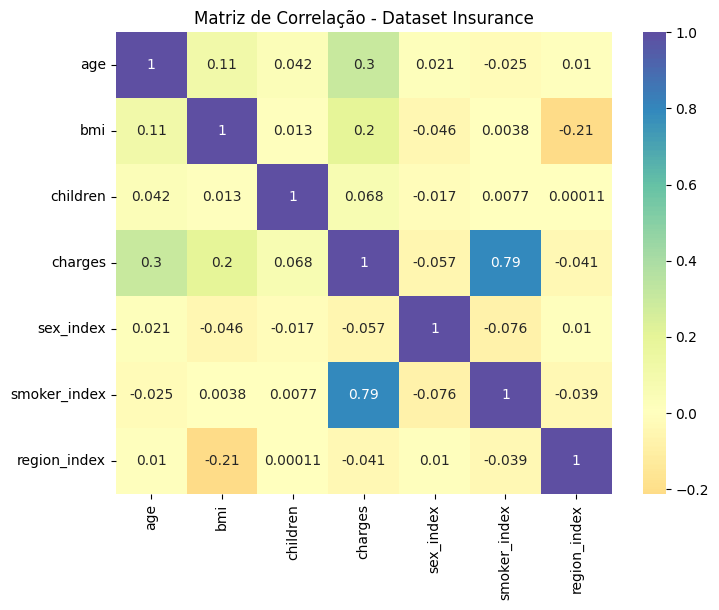

In [66]:
plt.figure(figsize=(8,6))
sns.heatmap(corr_matrix, annot=True, cmap="Spectral", center=0)
plt.title("Matriz de Correlação - Dataset Insurance")
plt.show()

As variáveis com maior correlação com o custo do seguro saúde são:

1. smoker_index: Fumante ou não fumante
2. age: Idade
3. bmi: Índice de massa corporal



#### **Correlação de Pearson**

O coeficiente mede a força e a direção linear entre duas variáveis, variando entre 1 e -1.

- Correlação linear positiva perfeita: 1
- Nenhuma correlação: 0
- Correlação linear negativa perfeita: -1

As faixas de correlação mais praticadas são:
- Fraca: 0.2
- Moderada: 0.4
- Forte: 0.7
- Muito forte: 0.9

Ou seja, `smoker_index` tem uma correlação forte com o valor do seguro saúde, enquanto `age` e `bmi` possuem uma correlação fraca.

## Regressão Linear

In [55]:
# ========================================
# 5. Treinamento do modelo e avaliação
# ========================================

# Divisão entre treino (80%) e teste (20%)
train, test = final_data.randomSplit([0.8, 0.2], seed=42)

In [56]:
# Regressão Linear
lr = LinearRegression(featuresCol="features", labelCol="charges")
lr_model = lr.fit(train)

In [57]:
# Métricas do modelo
print("Coeficientes:", lr_model.coefficients)
print("Intercepto:", lr_model.intercept)

Coeficientes: [253.41062689867144,339.83064105925865,457.93005591206827,348.02171562844006,23837.78995963429,282.44477833847736]
Intercepto: -13123.44207690876


In [70]:
# O quanto cada feature impacta no resultado da Regressão Linear
for i in range(0, len(feature_cols)):
  print(f"{feature_cols[i]}: {lr_model.coefficients[i]}")

age: 253.41062689867144
bmi: 339.83064105925865
children: 457.93005591206827
sex_index: 348.02171562844006
smoker_index: 23837.78995963429
region_index: 282.44477833847736


### Avaliação do modelo de regressão linear

In [59]:
predictions = lr_model.transform(test)

evaluator = RegressionEvaluator(labelCol="charges", predictionCol="prediction")
rmse = evaluator.evaluate(predictions, {evaluator.metricName: "rmse"})
r2 = evaluator.evaluate(predictions, {evaluator.metricName: "r2"})

print(f"RMSE = {rmse:.2f}")
print(f"R² = {r2:.3f}")

RMSE = 6392.75
R² = 0.719


O modelo de Regressão Linear explica aproximadamente 72% da variação (R²) nos custos do seguro saúde, o que indica boa adequação ao problema. Já o erro quadrático médio (RMSE) indica que as previsões do modelo possuem um desvio de USD 6.392,75, em média.

## Propostas de melhoria:

- Alterar normalização das variáveis categóricas para One Hot Enconding
- Avaliar a linearidade dos dados
- Testar o uso de outros modelos, como RandomForest